In [1]:
#csv desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
from sklearn.metrics import f1_score
from keras.layers import GRU
from keras.layers import Bidirectional

Using TensorFlow backend.


In [3]:
df_ner = pd.read_csv("drive/My Drive/Colab Notebooks/entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


> a) En esta primera instancia trabajaremos con la tarea de realizar un NER tag (Named Entity Recognition) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo many to many, es decir, la entrada es una secuencia y la salida es una secuencia, sin shift, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar lemma en vez de la misma palabra?

In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

Se prefiere la ultilización de lemma debido a que una palabra se puede escribir de multiples formas de acuerdo al contexto en el cual se utilice, lemmatizer corresponde a la normalización de las palabras a su raiz.

In [5]:
dataset.head(13)

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


In [6]:
dataset.tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

Existen un total de 17 labels que determinan que tipo de frase se esta utilizando.

> Luego de esto cree una estructura que contendrá todas las sentencias u oraciones (lista de *lemmas*) y otra estructura que contendrá las etiquetas (lista de *tags*). **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**

In [0]:
n_used = 750000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
sentence, labels_sentence = list(), list()
lemmas,labels = set(), set()  #uniques
#Se recorre el dataset hasta la ultima palabra indicada por n_used
for fila in dataset.values[:n_used]:
    #Se determina si la palabra utilizada es el inicio de una horación
    if fila[-1]=="__START1__": 
        #Se guardan en el dataset la oracion con sus tags
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]

In [8]:
print("Total de sentencias:",len(dataX_raw))
print("Total de etiquetas:",len(labels))
print("Total de palabras:",len(lemmas))

Total de sentencias: 34308
Total de etiquetas: 17
Total de palabras: 15959


El dataset posee un total de 34308 oraciones etiquetadas con 17 posibles tags, ademas se cuenta con un total de 15959 palabras posibles a utilizar en una oración.

Debido a la naturaleza del lenguaje las dimensiones de cada ejemplo no son iguales para cada caso, dependiendo del contexto una oración puede estar constituida por 14 palabras o 30.

Es por esto que una red recurrente viene a ser una buena idea para trabajar con el dataset.

> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. ¿Se observa una ley Zipf? Realice un gráfico de la cantidad de datos por clase. Comente.

In [0]:
freqs_sentence = dict()
freqs_words = dict()
for sentence in dataX_raw:
    if len(sentence) not in freqs_sentence.keys():
        freqs_sentence[len(sentence)] = 1
    else:
        freqs_sentence[len(sentence)] += 1
    for word in sentence:
        if word not in freqs_words.keys():
            freqs_words[word] = 1
        else:
            freqs_words[word] += 1
            
freqs_tags = dict()
for sentence in dataY_raw:
    for tag in sentence:
        if tag != 'O':
          if tag not in freqs_tags.keys():
            freqs_tags[tag] = 1
          else:
            freqs_tags[tag] += 1

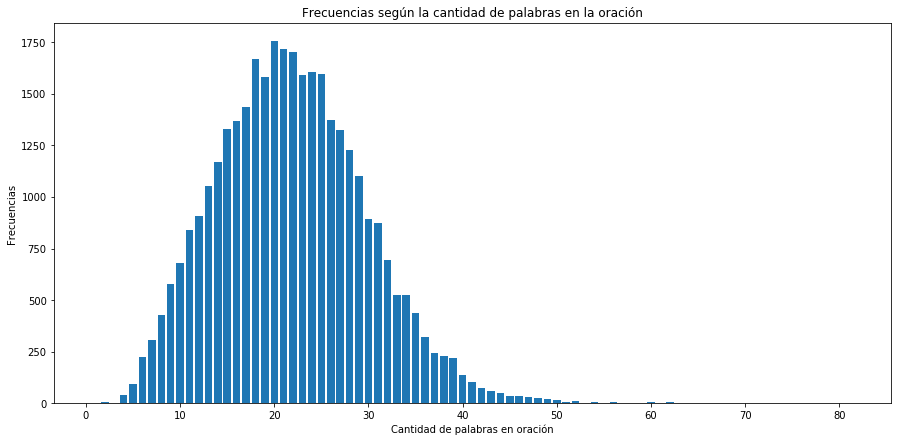

In [10]:
plt.figure(figsize=(15,7))

plt.bar(freqs_sentence.keys(), freqs_sentence.values())
plt.xlabel('Cantidad de palabras en oración')
plt.ylabel('Frecuencias')
plt.title('Frecuencias según la cantidad de palabras en la oración')

plt.show()

In [0]:
keys = list()
for key in freqs_words.keys():
    if freqs_words[key] < 800:
        keys.append(key)

for i in keys:
    del freqs_words[i]

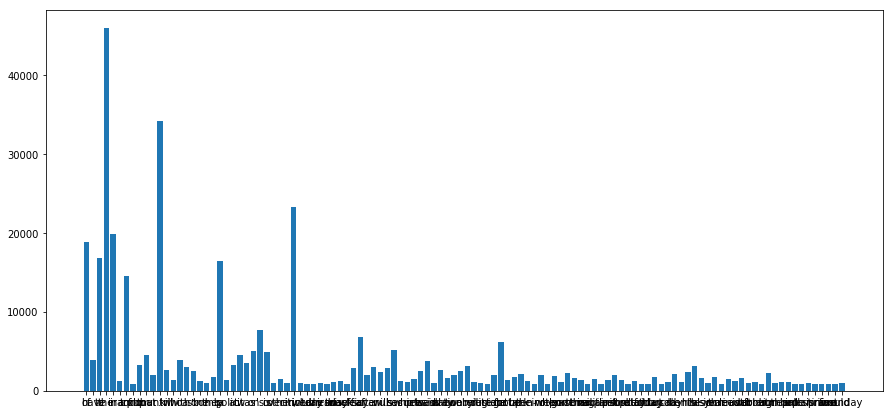

In [12]:
plt.figure(figsize=(15,7))

plt.bar(freqs_words.keys(), freqs_words.values())

plt.show()

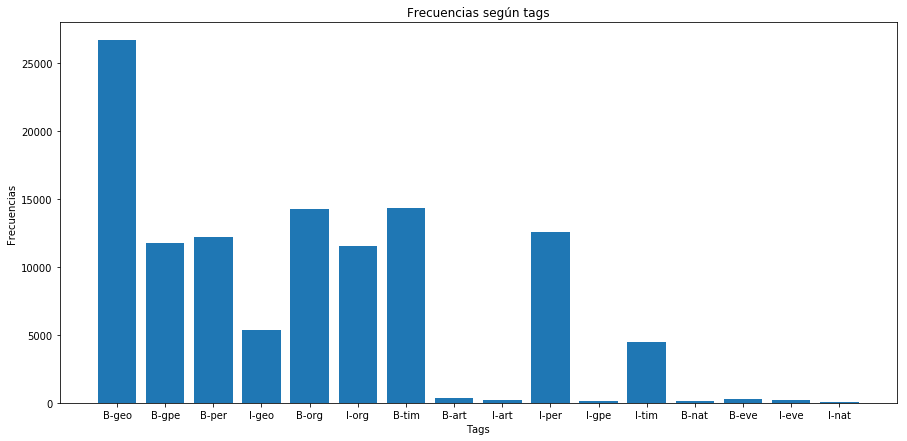

In [13]:
plt.figure(figsize=(15,7))

plt.bar(freqs_tags.keys(), freqs_tags.values())
plt.xlabel('Tags')
plt.ylabel('Frecuencias')
plt.title('Frecuencias según tags')

plt.show()

# COMPLETAR 

> c) Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**

In [0]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs
n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [15]:
print("Total de etiquetas:",len(lab2idx))
print("Total de palabras:",len(lemma2idx))

Total de etiquetas: 17
Total de palabras: 15959


Existen un total de 17 etiquetas posibles para cada sentencia y un total de 15959 distintos lemmas

# COMENTAR SIGNIFICADO DE TAGS

In [0]:
max_input_lenght = len(max(dataX, key=len))

El largo máximo corresponde a 81 palabras dentro de una sentencia.

> d) Debido a la distinta extensión de textos se deberá **realizar *padding* para estandarizar el largo**,
considere algun carácter especial **no presente en el vocabulario** para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*N, N*]. Decida, respecto al cómo funciona una red recurrente y su *memoria*, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente

In [0]:
lemma2idx["ANVORGESA"] = n_lemmas #add fullfill lemma and tag to the dictionary
lab2idx["ANVORGESA"] = n_labels
n_labels +=1
n_lemmas +=1
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=max_input_lenght,padding='post',value=lemma2idx["ANVORGESA"])
y = sequence.pad_sequences(dataY, maxlen=max_input_lenght,padding='post',value=lab2idx["ANVORGESA"])
del dataY[:],dataX[:]

Se decide utilizar realizar el padding posterior a la sentencia utilizada, esto es para que la etiqueta padding no influya en las decisiones posteriores del modelo.

> e) Para poder generar una representación adecuada sobre los datos de entrada que permita realizar operaciones lineales, deberá generar una representación a un vector denso. Para ésto se utilizará la arquitectura de autoencoder **Word2Vec** sobre textos *raws* de largo variable, en donde el *encoder* codifica una palabra categórica (*target*) a un vector denso de dimensionalidad $d$ mientras que el *decoder* genera palabras en el contexto (*context*) de la palabra *target* (en una vecindad alrededor). La idea detrás es que palabras similares sean proyectadas a una región cercana en el espacio de *embedding* ¿Cuál es la importancia del parámetro min_count? ¿Cuántos *lemmas* ve Word2Vec?

In [18]:
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 5
model = Word2Vec(dataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}
len(embeddings_index.keys())

6500

El atributo min_count determina la cantidad minima de apariciones que debe tener una palabra para ser considerada dentro de la representación, si se ignora dicho parámetro entonces la función utilizara palabras que aparecen una unica vez, esto genera que el tamaño de la matriz a generar sea muy grande, considerando que existen 15959.

Genere una matriz de *embeddings* que se utilizarán como capa neuronal.

In [0]:
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector

Luego, para poder realizar una clasificación sobre los datos en la salida será necesario representarlos *one hot vectors*, esto resultará en un arreglo tridimensional.

In [0]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

> f) Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [22]:
print("X train shape:",X_train.shape,"test:",X_test.shape)
print("y train shape:",y_train.shape,"test:",y_test.shape)

X train shape: (24015, 81) test: (10293, 81)
y train shape: (24015, 81, 18) test: (10293, 81, 18)


El conjunto de entrenamiento cuenta con 24015, mientras que el de testing cuenta con 10293.

Para las dimensiones los atributos con los que cuenta cada ejemplo corresponde al texto que lleva cada ejemplo, se define un tamaño 81 correspondiente a la máxima cantidad de palabras posibles para generar una sentencia (para este caso), el conjunto "y" cuenta ademas con una ultima dimension que contiene el tag de cada frase.

> g) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red es una por cada instante de tiempo que se necesita entregar un *output*. La primera capa de la red a construir debe tener los vectores de *embedding* encontrados por **Word2Vec**. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**. Entrene y luego evalúe su desempeño sobre ambos conjuntos. 

In [23]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')

W0617 17:55:56.374218 139698283853696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 17:55:56.398110 139698283853696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 17:55:56.400904 139698283853696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 17:55:56.411267 139698283853696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 17:55:56.411988 1396982838

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 81, 18)            1818      
Total params: 565,738
Trainable params: 55,018
Non-trainable params: 510,720
_________________________________________________________________


In [24]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

W0617 17:55:57.534337 139698283853696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases como identificó en el punto b). Tenga presente en este punto el **no evaluar** la clase/símbolo que añadió para realizar *padding* a los *tag*.  
*Hint: podría "truncar" la salida predicha hasta el largo real de esa sentencia*.

In [0]:
def predict_and_truncate(model, X_test, y_test):
  dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol

  dataY_pred_truncated = list()

  y_test_transformed = list()
  for example in y_test:
     y_test_transformed.append([np.argmax(y, axis=None, out=None) for y in example])

  y_test_t_t = list()

  sentence_index = 0
  for sentence in X_test:
    word_index = 0
    for word in sentence:
      if word == lemma2idx["ANVORGESA"]:
        dataY_pred_truncated.append(dataY_pred[sentence_index][:word_index])
        y_test_t_t.append(y_test_transformed[sentence_index][:word_index])
        break
      word_index += 1
    sentence_index += 1
    
  return dataY_pred_truncated, y_test_t_t

In [26]:
y_pred, y_test_t = predict_and_truncate(model, X_test, y_test)

f1_score_bydata = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]
print("\nF1 score on test: ", np.mean(f1_score_bydata) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score on test:  0.9108896682128195


> h) Varíe con seguir entrenando la capa de embedding seteada al definir la arquitectura, ésto es cambiar a *trainable=True*, compare el desempeño y el número de parámetros (entrenables) con lo anterior. Comente

In [0]:
modelt = Sequential()
modelt.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
modelt.add(LSTM(units=100,return_sequences=True))
modelt.add(Dropout(0.2))
modelt.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelt.compile(loss='categorical_crossentropy', optimizer='adam')

In [28]:
print("Original")
print(model.summary())
print("\nModified")
print(modelt.summary())

Original
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 81, 18)            1818      
Total params: 565,738
Trainable params: 55,018
Non-trainable params: 510,720
_________________________________________________________________
None

Modified
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 32)            510720    
_________________________________________

In [29]:
modelt.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=1)

Train on 24015 samples, validate on 10293 samples
Epoch 1/15
24015/24015 [==============================] - 29s 1ms/step - loss: 0.4514 - val_loss: 0.1777
Epoch 2/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.1337 - val_loss: 0.0989
Epoch 3/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0837 - val_loss: 0.0696
Epoch 4/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0625 - val_loss: 0.0573
Epoch 5/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0525 - val_loss: 0.0508
Epoch 6/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0467 - val_loss: 0.0470
Epoch 7/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0428 - val_loss: 0.0446
Epoch 8/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0398 - val_loss: 0.0431
Epoch 9/15
24015/24015 [==============================] - 28s 1ms/step - loss: 0.0373 - val_loss: 0.0415
Epoch

In [30]:
y_pred, y_test_t = predict_and_truncate(modelt, X_test, y_test)

f1_score_bydata2 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score new model on test: ", np.mean(f1_score_bydata2) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.9108896682128195

F1 score new model on test:  0.9573225807247627


> i) Experimente con cambiar la *gate* de recurrencia a una con menos parámetros pero que mantiene la capacidad de memoria de la LSTM, ésta es la compuerta GRU. Comente sobre los resultados esperados y observados.

In [0]:
modelg = Sequential()
modelg.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
modelg.add(GRU(units=100,return_sequences=True))
modelg.add(Dropout(0.2))
modelg.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelg.compile(loss='categorical_crossentropy', optimizer='adam')

In [32]:
print("LSTM")
print(modelt.summary())
print("\nGRU")
print(modelg.summary())

LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 32)            510720    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 81, 18)            1818      
Total params: 565,738
Trainable params: 565,738
Non-trainable params: 0
_________________________________________________________________
None

GRU
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 32)            510720    
_______________________________________________________

In [33]:
modelg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=1)

Train on 24015 samples, validate on 10293 samples
Epoch 1/15
24015/24015 [==============================] - 25s 1ms/step - loss: 0.4967 - val_loss: 0.1497
Epoch 2/15
24015/24015 [==============================] - 24s 993us/step - loss: 0.1119 - val_loss: 0.0829
Epoch 3/15
24015/24015 [==============================] - 24s 993us/step - loss: 0.0701 - val_loss: 0.0603
Epoch 4/15
24015/24015 [==============================] - 24s 994us/step - loss: 0.0546 - val_loss: 0.0516
Epoch 5/15
24015/24015 [==============================] - 24s 994us/step - loss: 0.0470 - val_loss: 0.0470
Epoch 6/15
24015/24015 [==============================] - 24s 996us/step - loss: 0.0424 - val_loss: 0.0439
Epoch 7/15
24015/24015 [==============================] - 24s 999us/step - loss: 0.0390 - val_loss: 0.0420
Epoch 8/15
24015/24015 [==============================] - 24s 1ms/step - loss: 0.0364 - val_loss: 0.0406
Epoch 9/15
24015/24015 [==============================] - 24s 993us/step - loss: 0.0342 - val_loss

In [34]:
y_pred, y_test_t = predict_and_truncate(modelg, X_test, y_test)

f1_score_bydata3 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score trainable model on test: ", np.mean(f1_score_bydata2) )
print("\nF1 score gru model on test: ", np.mean(f1_score_bydata3) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



F1 score original model on test:  0.9108896682128195

F1 score trainable model on test:  0.9573225807247627

F1 score gru model on test:  0.9595312090687417


> j) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas*. Comente cuál debiera ser la forma correcta de usar el parámetro merge_mode (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.

In [0]:
modelb = Sequential()
modelb.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
gate_layer = LSTM(units=100,return_sequences=True)
modelb.add(Bidirectional(gate_layer, merge_mode='concat'))
modelb.add(Dropout(0.2))
modelb.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelb.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
modelb.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=1)

Train on 24015 samples, validate on 10293 samples
Epoch 1/15
24015/24015 [==============================] - 64s 3ms/step - loss: 0.3938 - val_loss: 0.1377
Epoch 2/15
24015/24015 [==============================] - 62s 3ms/step - loss: 0.1023 - val_loss: 0.0747
Epoch 3/15
24015/24015 [==============================] - 62s 3ms/step - loss: 0.0645 - val_loss: 0.0555
Epoch 4/15
24015/24015 [==============================] - 63s 3ms/step - loss: 0.0504 - val_loss: 0.0474
Epoch 5/15
24015/24015 [==============================] - 63s 3ms/step - loss: 0.0432 - val_loss: 0.0429
Epoch 6/15
24015/24015 [==============================] - 62s 3ms/step - loss: 0.0384 - val_loss: 0.0399
Epoch 7/15
24015/24015 [==============================] - 63s 3ms/step - loss: 0.0351 - val_loss: 0.0390
Epoch 8/15
24015/24015 [==============================] - 62s 3ms/step - loss: 0.0323 - val_loss: 0.0361
Epoch 9/15
24015/24015 [==============================] - 63s 3ms/step - loss: 0.0299 - val_loss: 0.0350
Epoch

In [37]:
y_pred, y_test_t = predict_and_truncate(modelb, X_test, y_test)

f1_score_bydata4 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score trainable model on test: ", np.mean(f1_score_bydata2) )
print("\nF1 score gru model on test: ", np.mean(f1_score_bydata3) )
print("\nF1 score bidirectional model on test: ", np.mean(f1_score_bydata4) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.9108896682128195

F1 score trainable model on test:  0.9573225807247627

F1 score gru model on test:  0.9595312090687417

F1 score bidirectional model on test:  0.9653660307940953


> k) En base a lo experimentado, **mejore el desempeño de las redes encontradas**, ya sea utilizando y/o combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (en https://keras.io/layers/recurrent/), cambiar los vectores de *embedding* por unos entrenados en otros dataset más grandes (https://nlp.stanford.edu/projects/glove/), entre otros.

In [0]:
modelf = Sequential()
modelf.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
gate_layer = GRU(units=100,return_sequences=True)
modelf.add(Bidirectional(gate_layer, merge_mode='concat'))
modelf.add(Dropout(0.2))
modelf.add(TimeDistributed(Dense(n_labels, activation='softmax')))
modelf.compile(loss='categorical_crossentropy', optimizer='adam')

In [39]:
modelb.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)

In [40]:
y_pred, y_test_t = predict_and_truncate(modelf, X_test, y_test)

f1_score_bydata5 = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_t,y_pred) ]

print("\nF1 score original model on test: ", np.mean(f1_score_bydata) )
print("\nF1 score trainable model on test: ", np.mean(f1_score_bydata2) )
print("\nF1 score gru model on test: ", np.mean(f1_score_bydata3) )
print("\nF1 score bidirectional model on test: ", np.mean(f1_score_bydata4) )
print("\nF1 score bidirectional and gru model on test: ", np.mean(f1_score_bydata5) )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 score original model on test:  0.9108896682128195

F1 score trainable model on test:  0.9573225807247627

F1 score gru model on test:  0.9595312090687417

F1 score bidirectional model on test:  0.9653660307940953

F1 score bidirectional and gru model on test:  0.006559330776973842


> l) Utilice la red con mejor desempeño encontrada, idealmente la encontrada en (j), y **muestre las predicciones** del *NER tager*, sobre algún ejemplo de pruebas, comente. 

In [0]:
inv_lemma = {v: k for k, v in lemma2idx.items()}
inv_labels = {v: k for k, v in lab2idx.items()}

In [60]:
p = modelf.predict([[X_test[0]]])  #(np.array([X_test[0]]))
p = np.argmax(p, axis=-1)

labels_list = list(labels)
lemmas_list = list(lemmas)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[0],p[0]):
    print("{:15}: {}".format(inv_lemma[w],inv_labels[pred]))

[12828 15107 14816  5634 15673  1346  3313  7171  1037 10701 13266 15959
 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959
 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959
 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959
 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959
 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959 15959
 15959 15959 15959 15959 15959 15959 15959 15959 15959]
Lemma          : Pred
a              : ANVORGESA
separ          : ANVORGESA
prize          : B-geo
for            : B-geo
econom         : B-geo
will           : B-geo
be             : B-geo
announc        : B-geo
octob          : B-geo
10             : B-geo
.              : B-geo
ANVORGESA      : B-geo
ANVORGESA      : B-geo
ANVORGESA      : B-geo
ANVORGESA      : B-geo
ANVORGESA      : B-geo
ANVORGESA      : B-geo
ANVORGESA      : B-geo
ANVORGESA      : O
ANVORGESA      : O
ANVORGESA      : O
ANVOR